Enfoque del dataset de noticias falsas basado en CNN

In [5]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cargar Dataset

In [6]:
### DRIVE DATA ###
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
PATH = "/content/drive/My Drive/TFM/Data/FakeNews_Multi/"

Mounted at /content/drive


In [7]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "train.csv",  sep=',', on_bad_lines='skip')
df = df[['Text', 'Labels']]
df=df.rename(columns={"Text": "Text", "Labels": "Label"})

X = df['Text']
y = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=0.30, random_state=55, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=2/3, random_state=55, stratify=y_aux)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 7168
Tamaño conjunto de Validación: 1024
Tamaño conjunto de Evaluación: 2048


# Label Encoding

In [8]:
### LABEL ENCODING ###
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}


# Tokenización

In [9]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 10492


In [11]:
# Análisis de Longitud #
Length = pd.DataFrame({'Text': X_train})
Length['Length'] = Length['Text'].apply(lambda text: len(text.split()))
Length['Length'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    7168.000000
mean       18.013532
std         8.587241
min         2.000000
25%        12.000000
50%        17.000000
75%        22.000000
90%        29.000000
95%        33.000000
99%        41.000000
max       309.000000
Name: Length, dtype: float64

In [12]:
MAX_LEN = 41

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# CNN

In [15]:
EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 200)           2098400   
                                                                 
 conv1d_3 (Conv1D)           (None, 41, 128)           102528    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 20, 128)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 20, 64)            24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 32)           

Training:

In [16]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/20
448/448 [==============================] - 23s 46ms/step - loss: 1.7510 - accuracy: 0.2185 - val_loss: 1.7478 - val_accuracy: 0.2246
Epoch 2/20
448/448 [==============================] - 20s 45ms/step - loss: 1.6480 - accuracy: 0.2863 - val_loss: 1.7503 - val_accuracy: 0.2432
Epoch 3/20
448/448 [==============================] - 21s 46ms/step - loss: 1.3089 - accuracy: 0.4682 - val_loss: 2.0363 - val_accuracy: 0.2383
Epoch 4/20
448/448 [==============================] - 19s 43ms/step - loss: 0.7097 - accuracy: 0.7302 - val_loss: 2.7177 - val_accuracy: 0.2285


Curvas de Aprendizaje:

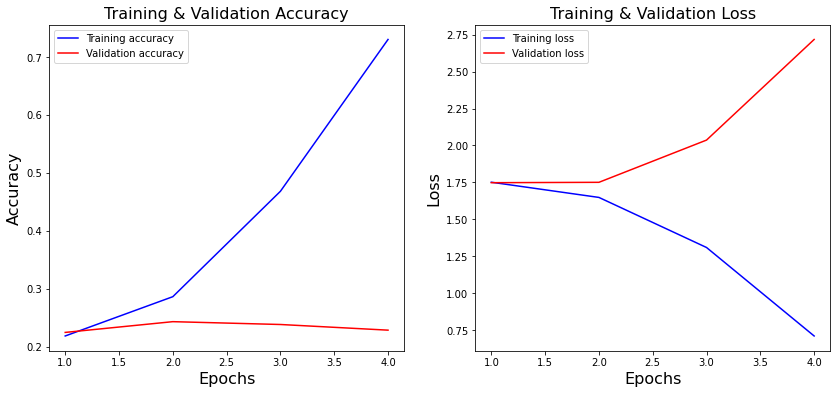

In [18]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluación:

64/64 [==============================] - 1s 10ms/step
Accuracy: 0.220703125
              precision    recall  f1-score   support

           0       0.19      0.35      0.24       330
           1       0.25      0.17      0.20       399
           2       0.23      0.31      0.26       423
           3       0.24      0.24      0.24       393
           4       0.31      0.11      0.17       168
           5       0.19      0.08      0.11       335

    accuracy                           0.22      2048
   macro avg       0.23      0.21      0.20      2048
weighted avg       0.23      0.22      0.21      2048

[[114  41  86  55  11  23]
 [128  68 106  54  13  30]
 [121  61 132  79  10  20]
 [101  42 124  93   4  29]
 [ 68  28  30  17  19   6]
 [ 75  36 108  86   4  26]]


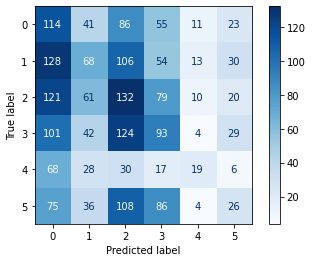

In [20]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('Accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0','1','2','3', '4', '5']))

cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1','2','3', '4', '5'])
disp.plot(cmap=plt.cm.Blues,values_format='g')